# Chutes and Ladders with QLearning Methods
This notebook uses QLearning to solve the Chutes and Ladders modified game.

The game board is shown below.  Players start on Square 0 (outside the board) and move towards the goal space (State 100).  Landing at the bottom of ladder moves the player to the top, while landing at the top of a chute moves the player to the bottom square.  


<img src="https://drive.google.com/uc?export=view&id=16k2EflsluUXCPVWVgL-vyv5-IzOqWZvW" alt="Drawing" width="500"/>


At each turn, the player may choose one of four dice (Effron Dice)
- Blue: 3,3,3,3,3,3
- Black: 4,4,4,4,0,0
- Red: 6,6,2,2,2,2
- Green: 5,5,5,1,1,1

The **purpose** of this code is to determine which dice to select at each turn so as to minimize the number of steps it takes to reach the goal state.  

In [29]:
# import statements
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


## State Transition Code

In [30]:
def nextState (state, roll):
    '''
    This function transitions from the current state and current dice roll to the next state.
    INPUTS:
        state is the current state you are in (0 to 100)
        roll is the number showing on the dice (1 to 6)
    RETURN VALUE:
    this function returns the next state integer
    '''
    # we create a dictionary for the ladders and chutes.  The key is the start state of the chute/ladder
    # and the value is the ending state.  
    ladders = {1:38,4:14,9:31,21:42,28:84,36:44,51:67,71:91,80:100}
    chutes = {16:6,48:26,49:11,56:53,62:19,64:60,87:24,93:73,95:75,98:78}
    
    next_state = state + roll
    if next_state > 100:
        next_state = 100
    # now check for ladders
    if next_state in ladders:
        next_state = ladders[next_state]
    # now check for chutes
    if next_state in chutes:
        next_state = chutes[next_state]
        
    return next_state
    
def roll (dice_color):
    '''
    This function randomly rolls one of the four effron dice.  
    INPUT:
    dice_color should be among "red","blue","black", or "green"
    OUTPUT:
    an integer randomly selected from one of the dice
    '''
    
    if dice_color == 0:                         # red dice 
        return random.choice([2,2,2,2,6,6])
    if dice_color == 1:                         # blue dice 
        return 3
    if dice_color == 2:                         # black dice 
        return random.choice([0,0,4,4,4,4])
    if dice_color == 3:                         # green dice 
        return random.choice([1,1,1,5,5,5])
    # for invalid input
    return None

In [31]:
def e_greedy(s, policy, epsilon):
    '''
    Implements an e-greedy policy.
    With probability epsilon, it returns random action choice
    otherwise returns action choice specified by the policy

    s = current state
    policy = policy function (an array that is indexed by state)
    epsilon (0 to 1) a probability of picking exploratory random action
    '''
    r = np.random.random()
    if r > epsilon:
        return policy[s]
    else:
        return random.randint(0,3)

In [32]:
def init(): 
    Q = np.zeros((101, 4)) 
    P = np.random.choice(4, 101)
    return Q, P 

In [33]:
def SARSA(Q, policy, alpha, epsilon): 
    '''
    Perform 1 trial of learning
    '''
    state = 0   # state 0 = outside the board
    action = e_greedy(state, policy, epsilon)   # choose a dice 
    total_reward = 0  # reward = number of throws

    # print("\n==== TRIAL ====")
    # print("state,action,reward: ({0:d},{1:d},{2:d})".format(state,action,reward))

    while (state < 100): 
        next_state = nextState(state, roll(action))
        next_action = e_greedy(state, policy, epsilon)
        total_reward += 1
        TDerror = 1 + Q[next_state, next_action] - Q[state, action]
        Q[state, action] = Q[state, action] + alpha * TDerror
        state = next_state
        action = next_action 
        # print("state,action,reward: ({0:d},{1:d},{2:d})".format(state,action,reward))

    TDerror = 1 + 0 - Q[state,action]
    Q[state,action] = Q[state,action] + alpha * TDerror
    return total_reward 

In [34]:
def QLearning(Q, policy, alpha, epsilon): 
    '''
    Perform 1 trial of learning
    '''
    state = 0   # state 0 = outside the board
    total_reward = 0  # reward = number of throws

    # print("\n==== TRIAL ====")
    # print("state,action,reward: ({0:d},{1:d},{2:d})".format(state,action,reward))

    while (state < 100): 
        action = e_greedy(state, policy, epsilon)   # choose a dice 
        next_state = nextState(state, roll(action))
        optimal_action = policy[next_state]
        total_reward += 1
        TDerror = 1 + Q[next_state,optimal_action] - Q[state,action]
        Q[state,action] = Q[state,action] + alpha * TDerror
        state = next_state
        # print("state,action,reward: ({0:d},{1:d},{2:d})".format(state,action,reward))

    TDerror = 1 + 0 - Q[state,action]
    Q[state,action] = Q[state,action] + alpha * TDerror
    return total_reward 

In [35]:
def do_SARSA_trials(Q, policy, n, alpha, epsilon): 
    '''
    Perform n trials of learning 
    '''
   # min_reward = 10000
    total_reward = 0
    for i in range(n): 
        x = SARSA(Q, policy, alpha, epsilon)
        #min_reward = min(min_reward, x)
        total_reward += x
    return total_reward/n

In [36]:
def do_QL_trials(Q, policy, n, alpha, epsilon): 
    '''
    Perform n trials of learning 
    '''
    #min_reward = 10000
    total_reward = 0
    for i in range(n): 
        x = QLearning(Q, policy, alpha, epsilon)
        total_reward += x
    return total_reward/n

In [37]:
def policy_evaluation(totals,counts,policy,n,epsilon):
  '''
  do n trajectories of learning
  and update the v/count arrays
  '''
  for i in range(n):
    t = make_trajectory(policy,epsilon)
    m = len(t)
    #print(m,t)
    sum_r = np.zeros(m)
    sum_r[m-1] = t[-1][2]
    for j in range(m-2,-1,-1):
      sum_r[j] = sum_r[j+1] + t[j][2]
    #print(sum_r)

    for j in range(m):
      s,a,r = t[j]
      counts[s,a] += 1
      totals[s,a] += sum_r[j]

In [38]:
def policy_improvement(Q):
  '''
  Update value function V and policy P based on Q values
  '''
  V = np.min(Q, axis=1)
  P = np.argmin(Q, axis=1)
  return V, P

In [39]:
#-------------------------------------------------------------
def assess (policy,trials):
  '''
  Assess the value of the current policy by completing #trials
  using the specified policy (no e-greedy random actions)
  Does not accrue learning experience nor change policy
  '''
  R = 0
  for i in range(trials):
    R += policy_evaluation(totals,counts,policy,trials,0.1)
    Q = compute_Q(totals,counts)
    V,P = policy_improvement(Q)
  return V[0]

#-------------------------------------------------------------

def make_trajectory (policy,epsilon):
  '''
  Simulate one trajectory of experience
  Return list of tuples during trajectory
  Each tuple is (s,a,r) -> state / action / reward
  epsilon = probability of exploratory action
  '''
  traj = []
  s=0   #  turn 0, pot 0
  total_reward = 0
  stop = 0
  while (s < 100) and stop < 20:
    a = e_greedy(s,policy,epsilon)
    s_prev = s
    action_dice = roll(a)
    s = nextState(s,action_dice)
    total_reward+=1
    traj.append((s_prev,a,1))
    stop += 1
  # final reward = state value, final action = 0 (meaningless)
  traj.append((s,0,1))
  return traj,total_reward

In [40]:
def assess_policy(P, n):
  total_r = 0
  for i in range(n):
    traj, r = make_trajectory(P, 0)
    total_r += r
  return total_r/n

In [41]:
"""
SARSA Learning
"""

m = 100
n = 1000

perf1 = []
perf2 = []
perf3 = []
perf4 = []
x_axis = [i for i in range(1,m+1)]
for e in range(1, 5, 1):
  Q, P = init()
  epsilon = e/10
  alpha = 0.1
  total_reward = 0

  for i in range(m):
    reward = do_SARSA_trials(Q, P, n, alpha, epsilon)
    #min_reward = min(reward, min_reward)
    V, P = policy_improvement(Q)
    total_reward += reward 
    
    #performance.append(total_reward/(n))
    if epsilon == 0.1:
      perf1.append(assess_policy(P, n))
    if epsilon == 0.2:
      perf2.append(assess_policy(P, n))
    if epsilon == 0.3:
      perf3.append(assess_policy(P, n))
    if epsilon == 0.4:
      perf4.append(assess_policy(P, n))
    #x_axis.append(i)

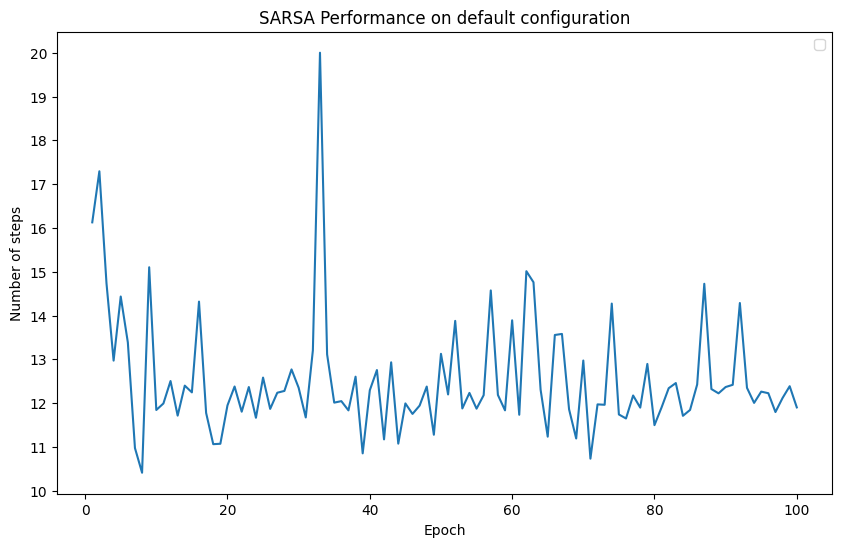

In [42]:
# plot lines
plt.figure(figsize=(10,6))
plt.plot(x_axis, perf1)
#plt.plot(x_axis, perf2, label = "e = 0.2", color = "gray")
#plt.plot(x_axis, perf3, label = "e = 0.3", color = "gray")
#plt.plot(x_axis, perf4, label = "e = 0.4", color = "orange")
ticks = [10,11,12,13,14,15,16,17,18,19,20]
#plt.yticks(perf1, ticks)
plt.xlabel("Epoch")
plt.ylabel("Number of steps")
plt.title("SARSA Performance on default configuration")
#plt.ylim([10,11,12,13,14,15,16,17,18,19,20,21])
plt.yticks(np.arange(10, 21, 1))
plt.legend()
plt.show()

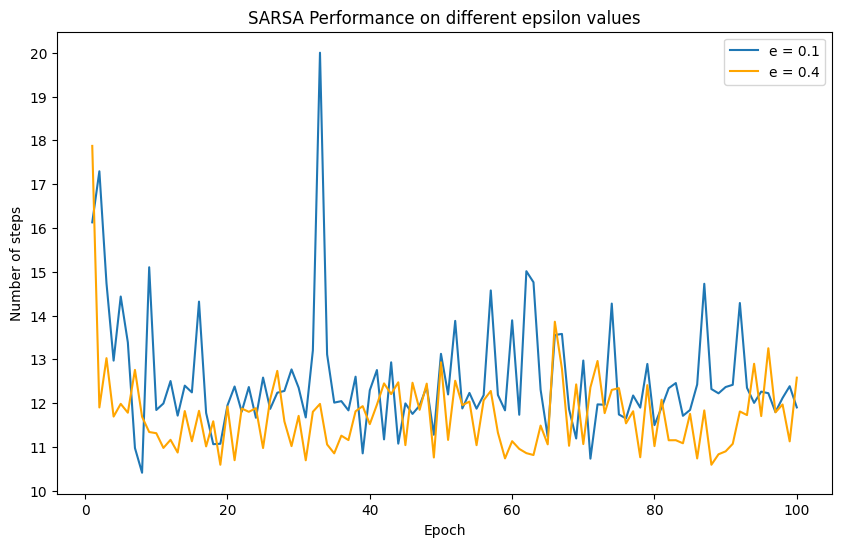

In [43]:
# plot lines
plt.figure(figsize=(10,6))
plt.plot(x_axis, perf1, label = "e = 0.1")
#plt.plot(x_axis, perf2, label = "e = 0.2", color = "gray")
#plt.plot(x_axis, perf3, label = "e = 0.3", color = "gray")
plt.plot(x_axis, perf4, label = "e = 0.4", color = "orange")
plt.title("SARSA Performance on different epsilon values")
plt.xlabel("Epoch")
plt.ylabel("Number of steps")
plt.yticks(np.arange(10, 21, 1))
plt.legend()
plt.show()

In [44]:
print("Min of SARSA: ",min(perf4))

Min of SARSA:  10.595


In [45]:
"""
Q Learning
"""

m = 100
n = 1000

perf1_q = []
perf2_q = []
perf3_q = []
perf4_q = []
x_axis_q = [i for i in range(1,m+1)]
for e in range(1, 5, 1):
  Q, P = init()
  epsilon = e/10
  alpha = 0.1
  total_reward = 0

  for i in range(m):
    reward = do_QL_trials(Q, P, n, alpha, epsilon)
    #min_reward = min(reward, min_reward)
    V, P = policy_improvement(Q)
    total_reward += reward 
    
    #performance.append(total_reward/(n))
    if epsilon == 0.1:
      perf1_q.append(assess_policy(P, n))
    if epsilon == 0.2:
      perf2_q.append(assess_policy(P, n))
    if epsilon == 0.3:
      perf3_q.append(assess_policy(P, n))
    if epsilon == 0.4:
      perf4_q.append(assess_policy(P, n))
    #x_axis.append(i)

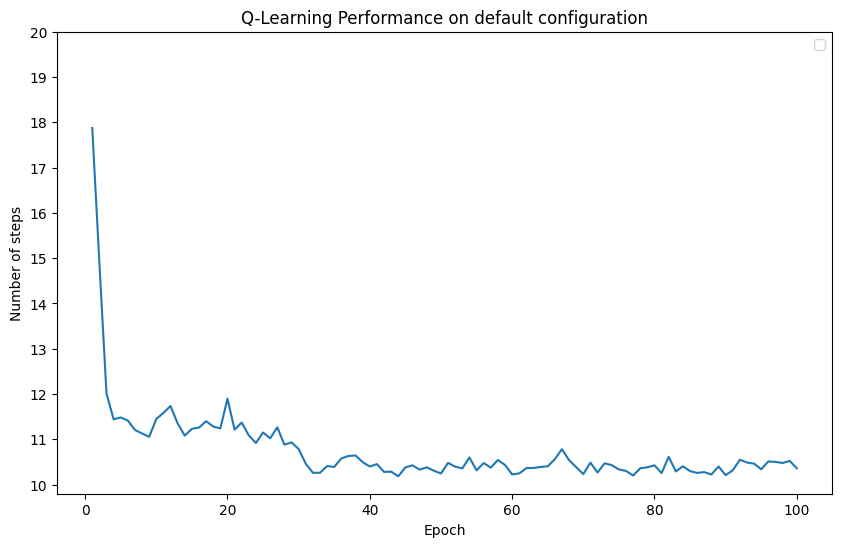

In [46]:
# plot lines
plt.figure(figsize=(10,6))
plt.plot(x_axis_q, perf1_q)
#plt.plot(x_axis, perf2, label = "e = 0.2", color = "gray")
#plt.plot(x_axis, perf3, label = "e = 0.3", color = "gray")
#plt.plot(x_axis, perf4, label = "e = 0.4", color = "orange")
plt.xlabel("Epoch")
plt.ylabel("Number of steps")
plt.title("Q-Learning Performance on default configuration")
plt.yticks(np.arange(10, 21, 1))
plt.legend()
plt.show()

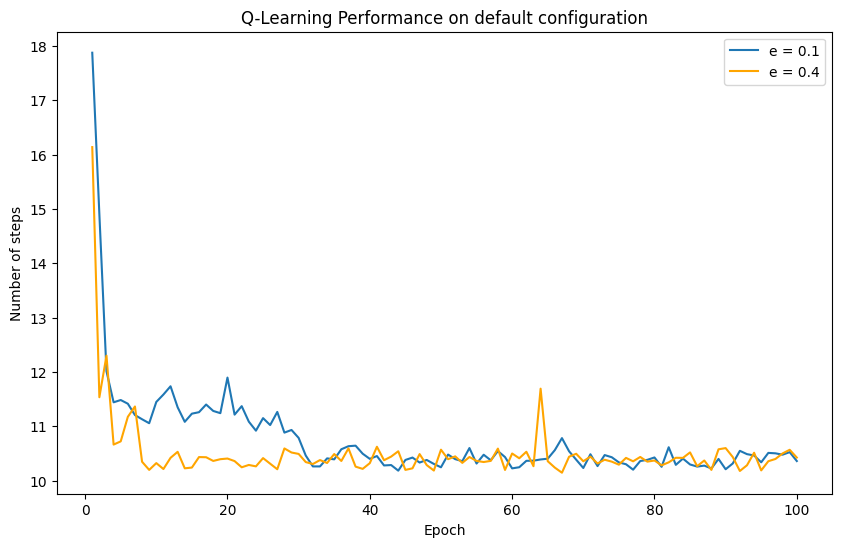

In [47]:
# plot lines
plt.figure(figsize=(10,6))
plt.plot(x_axis_q, perf1_q, label = "e = 0.1")
#plt.plot(x_axis, perf2, label = "e = 0.2", color = "gray")
#plt.plot(x_axis, perf3, label = "e = 0.3", color = "gray")
plt.plot(x_axis, perf4_q, label = "e = 0.4", color = "orange")
plt.xlabel("Epoch")
plt.ylabel("Number of steps")
plt.title("Q-Learning Performance on default configuration")
plt.yticks(np.arange(10, 19, 1))
plt.legend()
plt.show()

In [48]:
print("Min of Q-Learning: ",min(perf4_q))

Min of Q-Learning:  10.144


### Compute Standard Deviation:

In [49]:

print("Standard Deviation of SARSA with epsilon = 0.4: ", np.std(perf4))
print("Standard Deviation of Q-Learning with epsilon = 0.1: ", np.std(perf1_q))
print("Standard Deviation of Q-Learning with epsilon = 0.4: ", np.std(perf4_q))

Standard Deviation of SARSA with epsilon = 0.4:  0.9189613428213399
Standard Deviation of Q-Learning with epsilon = 0.1:  0.9379365191205637
Standard Deviation of Q-Learning with epsilon = 0.4:  0.6439934723271658


In [50]:

print("The optimal solution of Q-Learning: ")
print(Q)
print(V)
print(P)

The optimal solution of Q-Learning: 
[[12.66788692 12.63027037 12.04586631 11.64780935]
 [ 0.          0.          0.          0.        ]
 [12.2842871  12.04712381 11.9619595  12.30794745]
 [11.48277756 11.55717045 12.23859525 11.98775408]
 [ 0.          0.          0.          0.        ]
 [12.2061689  12.22247682 11.23477944 11.87507651]
 [12.28963197 10.47139999 12.5044486  12.30030525]
 [10.94286342 12.88307175 12.37672443 12.22763479]
 [12.38302345 12.54066531 12.23501072 11.11382719]
 [ 0.          0.          0.          0.        ]
 [11.89157995 12.02406646 12.13635761 11.85680679]
 [11.32040977 11.76654129 11.83622261 11.83881405]
 [11.17339031 11.33281232 11.65693812 11.35197626]
 [10.93956023 11.6747472  11.42407894 11.0584522 ]
 [10.93678098 10.79428817 10.76407442 10.63988882]
 [10.09767421 10.46078758 10.33540094 11.16592044]
 [ 0.          0.          0.          0.        ]
 [ 9.71131315  9.89992597  9.80387653 10.05346813]
 [ 9.57652016  9.32148812  9.77104332  9.4504

In [56]:
op_po = []
for i in P:
  if i == 0:
    op_po.append('red')
  if i == 1:
    op_po.append('blue')
  if i == 2:
    op_po.append('black')
  if i == 3:
    op_po.append('green')

In [57]:
op_po

['green',
 'red',
 'black',
 'red',
 'red',
 'black',
 'blue',
 'red',
 'green',
 'red',
 'green',
 'red',
 'red',
 'red',
 'green',
 'red',
 'red',
 'red',
 'blue',
 'red',
 'green',
 'red',
 'blue',
 'green',
 'black',
 'blue',
 'red',
 'green',
 'red',
 'red',
 'red',
 'green',
 'black',
 'blue',
 'red',
 'green',
 'red',
 'red',
 'green',
 'red',
 'green',
 'green',
 'blue',
 'blue',
 'blue',
 'red',
 'green',
 'black',
 'red',
 'red',
 'green',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'red',
 'red',
 'green',
 'red',
 'green',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'green',
 'blue',
 'green',
 'blue',
 'red',
 'red',
 'green',
 'blue',
 'red',
 'green',
 'black',
 'blue',
 'red',
 'green',
 'red',
 'green',
 'red',
 'blue',
 'red',
 'blue',
 'red',
 'red',
 'black',
 'green',
 'red',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'black',
 'blue',
 'red',
 'red',
 'red']

In [51]:
# """
# Perform SARSA learning
# """
# Q, P = init()
# m = 100
# n = 10000
# epsilon = 0.1
# alpha = 0.1

# total_reward = 0
# #min_reward = 10000 
# performance = []
# x_axis = []

# for i in range(m):
#   #total_reward = 0
#   #print("\n*** Trial {0:d} ***".format(i))
#   reward = do_SARSA_trials(Q, P, n, alpha, epsilon)
#   #min_reward = min(reward, min_reward)
#   V, P = policy_improvement(Q)
#   total_reward += reward 
  
#   #performance.append(total_reward/(n))
#   performance.append(assess_policy(P, n))
#   x_axis.append(i)
#   #print("Perf: ", reward)

# #print("Average Reward: {}".format(total_reward/m))
# # print(Q)
# # print(V)
# print(P)

# y_axis = performance

# plt.plot(x_axis, y_axis)
# plt.title('SARSA Performance')
# plt.xlabel('Epoch')
# plt.ylabel('Steps to 100')
# plt.show()

In [52]:
# value = assess(P,2000)
# print(value)

In [53]:
# """
# Perform QLearning 1 time
# """
# Q, P = init()
# m = 100
# n = 100
# epsilon = 0.2
# alpha = 0.1

# total_reward = 0
# min_reward = 100 
# performance = []
# x_axis = []

# for i in range(m):
#   #print("\n*** Trial {0:d} ***".format(i))
#   reward = do_QL_trials(Q, P, n, alpha, epsilon)
#   min_reward = min(reward, min_reward)
#   total_reward += reward
#   V, P = policy_improvement(Q)
#   performance.append(assess_policy(P,n))
#   #print("Perf: ", reward)
#   x_axis.append(i)
# #print("Min Step: {}".format(min_reward))
# # print("Average Reward: {}".format(total_reward/m))
# print(Q)
# print(V)
# print(P)

# y_axis = performance

# plt.plot(x_axis, y_axis)
# plt.title('QLearning Performance')
# plt.xlabel('Epoch')
# plt.ylabel('Steps to 100')
# plt.show()
